# Import Modules

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime
from time import time
from torch import nn, optim
from torch.nn import init
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torchmetrics import F1Score, ConfusionMatrix

# Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST("../datasets/", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("../datasets/", train=False, download=True, transform=transform)

# Dataloader

In [3]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

# Build Model

## Architecture

In [4]:
class Model(nn.Module):
    def __init__(self, n_feature, init_weight_bias=False):
        super(Model, self).__init__()
                
        self.input = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(n_feature, 64),
            nn.Dropout(p=0.1),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(64, 10),
            nn.ReLU()
        )
        
        self.output = nn.Softmax(dim=1)
        
        if init_weight_bias:
            self.init_weight_bias("fc1")
            self.init_weight_bias("fc2")
    
    def init_weight_bias(self, layer_name):
        for layer in self.get_submodule(layer_name):
            if isinstance(layer, nn.Linear):
                layer.weight = nn.parameter.Parameter(
                    init.kaiming_normal_(
                        tensor=torch.empty(layer.weight.shape),
                        a=0,
                        mode="fan_in",
                        nonlinearity="leaky_relu"
                    )
                )
            
                layer.bias = nn.parameter.Parameter(
                    init.kaiming_normal_(
                        tensor=torch.empty(layer.bias.shape[0], 1),
                        a=0,
                        mode="fan_in",
                        nonlinearity="leaky_relu"
                    ).flatten()
                )
    
    def forward(self, x):
        x_input = self.input(x)
        x_fc1 = self.fc1(x_input)
        x_fc2 = self.fc2(x_fc1)
        x_output = self.output(x_fc2)
        
        return x_output

model = Model(n_feature=28 * 28, init_weight_bias=False)
model

Model(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Softmax(dim=1)
)

## Loss

In [5]:
loss_metric = nn.NLLLoss()
loss_metric

NLLLoss()

## Metric

In [6]:
eval_metric = F1Score(num_classes=10)
eval_metric

F1Score()

## Optimizer 

In [7]:
optimizer = optim.Adam(model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## Loop Function

In [8]:
def train(dataloader, model, loss_metric, eval_metric, optimizer, time):
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write("Train\n")
        
    print("Train\n")
    
    losses = []
    
    for batch, (feature, actual_label) in enumerate(dataloader, 1):
        # Forward Propagation
        pred_label = model(feature)
        loss = loss_metric(pred_label, actual_label)
        metric = eval_metric(pred_label, actual_label)
        
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        losses.append(loss)
        
        if batch % 100 == 0 or batch == len(dataloader):
            print(f"Batch-{batch:<4} | F1-Score: {metric:>7f} | Loss: {loss:>7f}")
        
            with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
                f.write(f"Batch-{batch:<4} | F1-Score: {metric:>7f} | Loss: {loss:>7f}\n")
            
    metric = eval_metric.compute()
    loss = sum(losses) / len(dataloader)
    print(f"Accuracy : {metric}")
    print(f"Loss     : {loss}\n")
    
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write(f"Accuracy : {metric}\n")
        f.write(f"Loss     : {loss}\n\n")
        
    eval_metric.reset()
    
    return metric, loss

def validate(dataloader, model, loss_metric, eval_metric, time):
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write("Test\n")
        
    print("Test\n")
    
    model.train()
    losses = []
    
    for batch, (feature, actual_label) in enumerate(dataloader, 1):
        # Forward Propagation
        pred_label = model(feature)
        loss = loss_metric(pred_label, actual_label)
        metric = eval_metric(pred_label, actual_label)
        
        loss = loss.item()
        losses.append(loss)
        
        if batch % 100 == 0 or batch == len(dataloader):
            print(f"Batch-{batch:<4} | F1-Score: {metric:>7f} | Loss: {loss:>7f}")
        
            with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
                f.write(f"Batch-{batch:<4} | F1-Score: {metric:>7f} | Loss: {loss:>7f}\n")
            
    metric = eval_metric.compute()
    loss = sum(losses) / len(dataloader)
    print(f"Accuracy : {metric}")
    print(f"Loss     : {loss}")
    
    with open("../callbacks/" + str(time) + "/logs/history.txt", "a") as f:
        f.write(f"Accuracy : {metric}\n")
        f.write(f"Loss     : {loss}\n\n")
        
    eval_metric.reset()
    
    return metric, loss

def loop(train, validate, epochs=5):
    now = datetime.now()
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs("../callbacks/" + str(path_name) + "/models")
    os.makedirs("../callbacks/" + str(path_name) + "/logs")

    train_accuracies, train_losses = [], []
    test_accuracies, test_losses = [], []

    start = time()
    for epoch in range(epochs):
        with open("../callbacks/" + str(path_name) + "/logs/history.txt", "a") as f:
            f.write(f"EPOCH {epoch + 1}/{epochs}\n")
            f.write(f"{'=' * 50}\n")
            
        print(f"EPOCH {epoch + 1}/{epochs}")
        print("=" * 50, end="\n")
        acc_train, loss_train = train(train_loader, model, loss_metric, eval_metric, optimizer, path_name)
        acc_test, loss_test = validate(test_loader, model, loss_metric, eval_metric, path_name)
            
        print("=" * 50, end="\n\n")
        
        with open("../callbacks/" + str(path_name) + "/logs/history.txt", "a") as f:
            f.write(f"{'=' * 50}\n\n")
            
        train_accuracies.append(acc_train)
        train_losses.append(loss_train)
        test_accuracies.append(acc_test)
        test_losses.append(loss_test)
        
        torch.save(model.state_dict(), "../callbacks/" + path_name + "/models/epoch_" + str(epoch + 1).zfill(3) + ".pt")
    
    metrics = {
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "test_accuracies": test_accuracies,
        "test_losses": test_losses
    }
    
    torch.save(metrics, "../callbacks/" + path_name + "/logs/metrics.pt")

    print("SUMMARY:")
    print(f"Train Accuracy : {sum(train_accuracies) / len(train_accuracies)}")
    print(f"Train Loss     : {sum(train_losses) / len(train_losses)}\n")
    print(f"Test Accuracy  : {sum(test_accuracies) / len(test_accuracies)}")
    print(f"Test Loss      : {sum(test_losses) / len(test_losses)}")
    
    with open("../callbacks/" + path_name + "/logs/history.txt", "a") as f:
        f.write("SUMMARY:\n")
        f.write(f"Train Accuracy    : {sum(train_accuracies) / len(train_accuracies)}\n")
        f.write(f"Train Loss        : {sum(train_losses) / len(train_losses)}\n\n")
        f.write(f"Test Accuracy     : {sum(test_accuracies) / len(test_accuracies)}\n")
        f.write(f"Test Loss         : {sum(test_losses) / len(test_losses)}\n\n")
        f.write(f"Training Datetime : {now.strftime('%m/%d/%Y %H:%M:%S')}\n")
    
    stop = time()
    total_time = stop - start
    print(f"Training time     : {(total_time / 60):.3f} minutes")
    
    with open("../callbacks/" + path_name + "/logs/history.txt", "a") as f:
        f.write(f"Training time     : {(total_time / 60):.3f} minutes")
        
    return {"train_accuracies": train_accuracies, "train_losses": train_losses, "test_accuracies": test_accuracies, "test_losses": test_losses}

summary = loop(train, validate, 5)

EPOCH 1/5
Train

Batch-100  | F1-Score: 0.125000 | Loss: -0.160198
Batch-200  | F1-Score: 0.656250 | Loss: -0.660708
Batch-300  | F1-Score: 0.656250 | Loss: -0.643948
Batch-400  | F1-Score: 0.562500 | Loss: -0.557666
Batch-500  | F1-Score: 0.625000 | Loss: -0.635115
Batch-600  | F1-Score: 0.468750 | Loss: -0.497194
Batch-700  | F1-Score: 0.500000 | Loss: -0.517434
Batch-800  | F1-Score: 0.656250 | Loss: -0.664044
Batch-900  | F1-Score: 0.531250 | Loss: -0.551541
Batch-1000 | F1-Score: 0.562500 | Loss: -0.564918
Batch-1100 | F1-Score: 0.343750 | Loss: -0.361096
Batch-1200 | F1-Score: 0.625000 | Loss: -0.631899
Batch-1300 | F1-Score: 0.781250 | Loss: -0.792234
Batch-1400 | F1-Score: 0.687500 | Loss: -0.708184
Batch-1500 | F1-Score: 0.562500 | Loss: -0.601989
Batch-1600 | F1-Score: 0.531250 | Loss: -0.550171
Batch-1700 | F1-Score: 0.656250 | Loss: -0.650348
Batch-1800 | F1-Score: 0.500000 | Loss: -0.512509
Batch-1875 | F1-Score: 0.687500 | Loss: -0.672760
Accuracy : 0.5474166870117188
Los

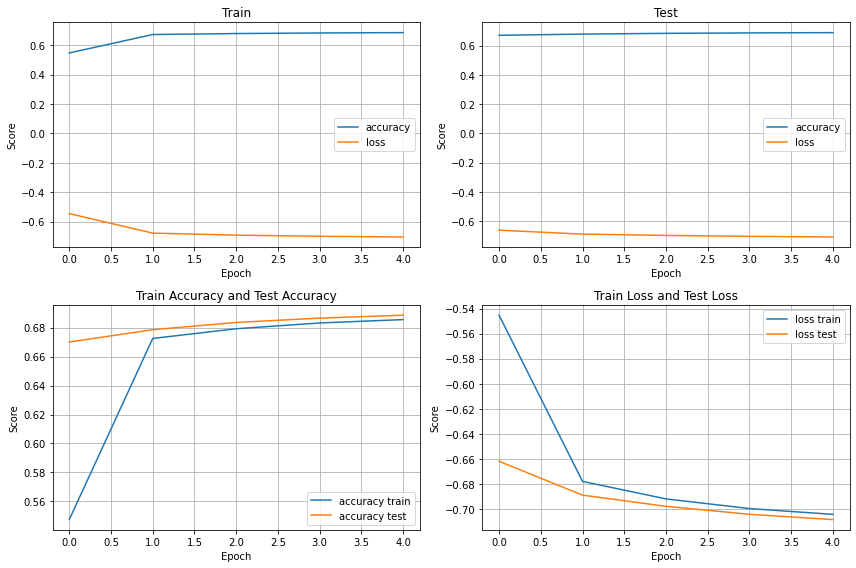

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(12, 8))

ax[0][0].set_title("Train")
ax[0][0].plot(summary["train_accuracies"], label="accuracy")
ax[0][0].plot(summary["train_losses"], label="loss")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Score")
ax[0][0].legend()
ax[0][0].grid();

ax[0][1].set_title("Test")
ax[0][1].plot(summary["test_accuracies"], label="accuracy")
ax[0][1].plot(summary["test_losses"], label="loss")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Score")
ax[0][1].legend()
ax[0][1].grid();

ax[1][0].set_title("Train Accuracy and Test Accuracy")
ax[1][0].plot(summary["train_accuracies"], label="accuracy train")
ax[1][0].plot(summary["test_accuracies"], label="accuracy test")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Score")
ax[1][0].legend()
ax[1][0].grid();

ax[1][1].set_title("Train Loss and Test Loss")
ax[1][1].plot(summary["train_losses"], label="loss train")
ax[1][1].plot(summary["test_losses"], label="loss test")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Score")
ax[1][1].legend()
ax[1][1].grid();

# Evaluate

## Predict with test dataset

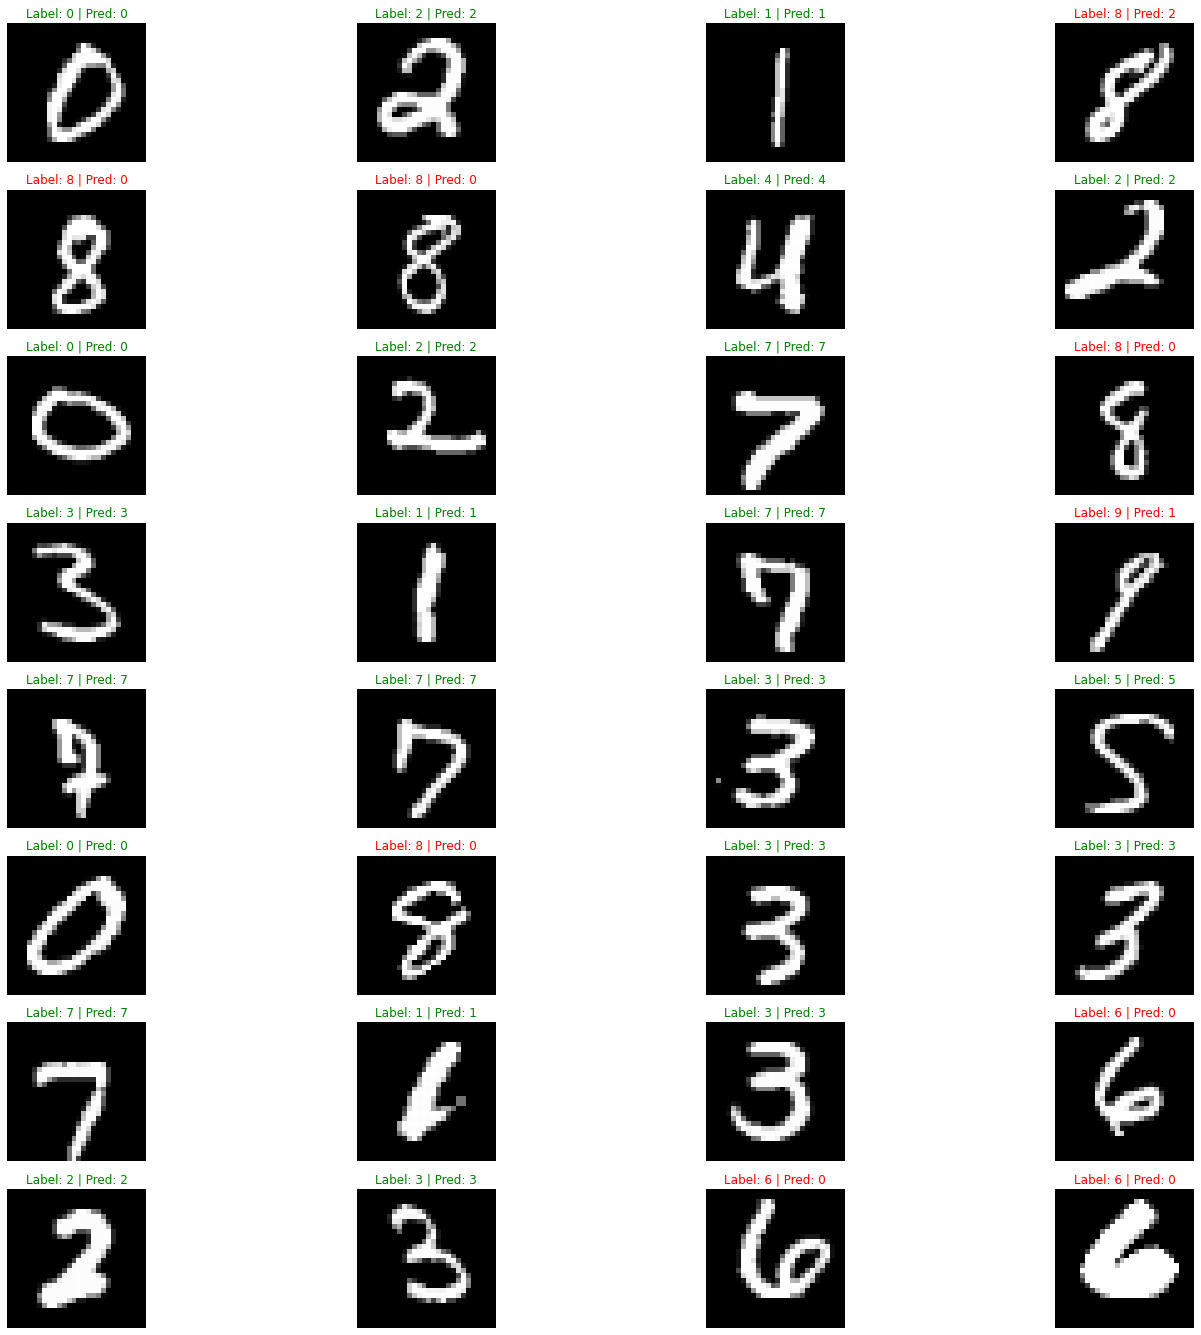

In [10]:
features, labels = next(iter(test_loader))

model.eval()
pred_labels = model(features).argmax(dim=1)

fig, axes = plt.subplots(8, 4, figsize=(24, 24))

for image, label, pred_label, ax in zip(features, labels, pred_labels, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    font = {"color": "red"} if label != pred_label else {"color": "green"}
    ax.set_title(f"Label: {label} | Pred: {pred_label}", fontdict=font)
    ax.axis("off")

## Confusion Matrix

In [11]:
def plot_confusion_matrix(model, dataloader):
    actual_labels = dataloader.dataset.targets
    features = dataloader.dataset.data.to(dtype=torch.float32)
    
    model.eval()
    pred_labels = model(features).argmax(dim=1)
    confusion_matrix = ConfusionMatrix(num_classes=10)
    
    ax = sns.heatmap(confusion_matrix(pred_labels, actual_labels), annot=True, fmt="d")
    ax.set(
        xlabel="Prediction",
        ylabel="Actual"
    );

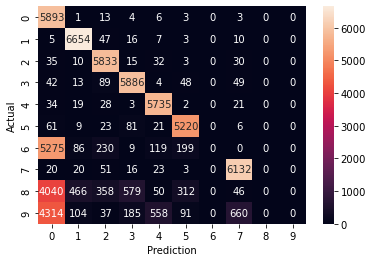

In [12]:
plot_confusion_matrix(model, train_loader)

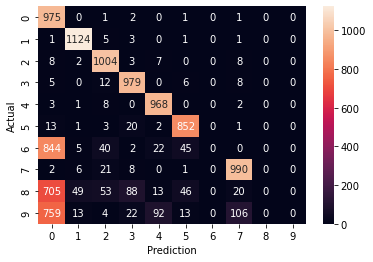

In [13]:
plot_confusion_matrix(model, test_loader)